# 1: IMPORTING LIBRARIES AND DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [3]:
data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [4]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [5]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_29.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_29_mask.tif


### creating final datset

In [7]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


# 2: DATA VISUALIZATION

In [8]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [9]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

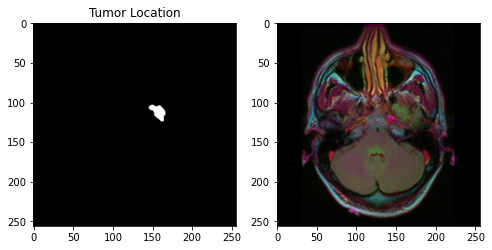

In [10]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [11]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

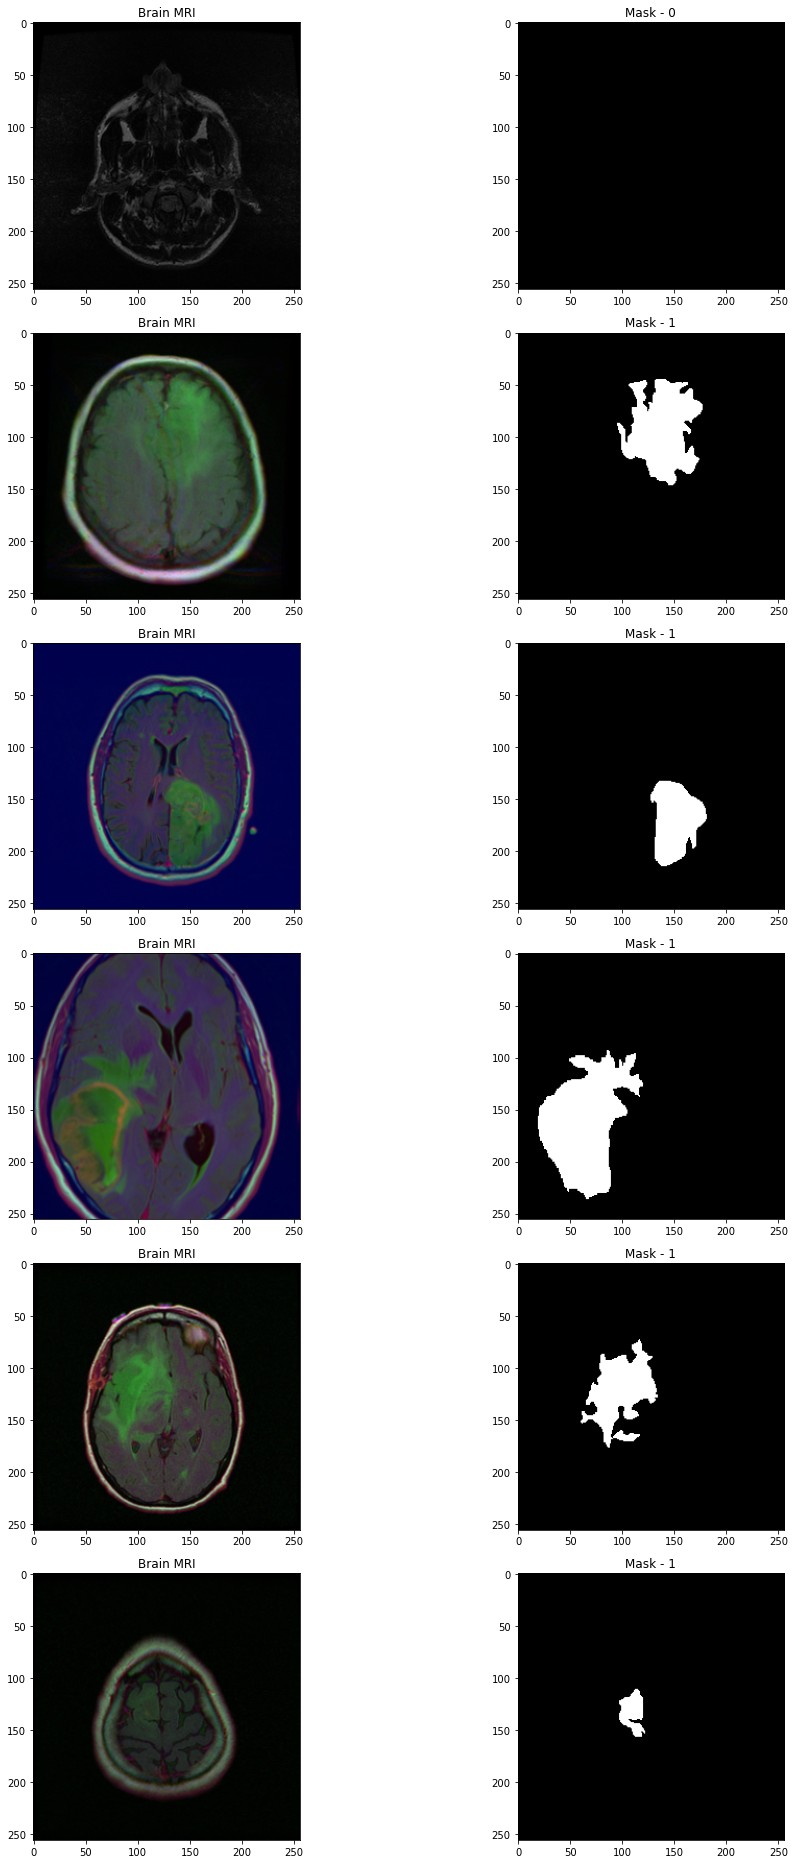

In [12]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

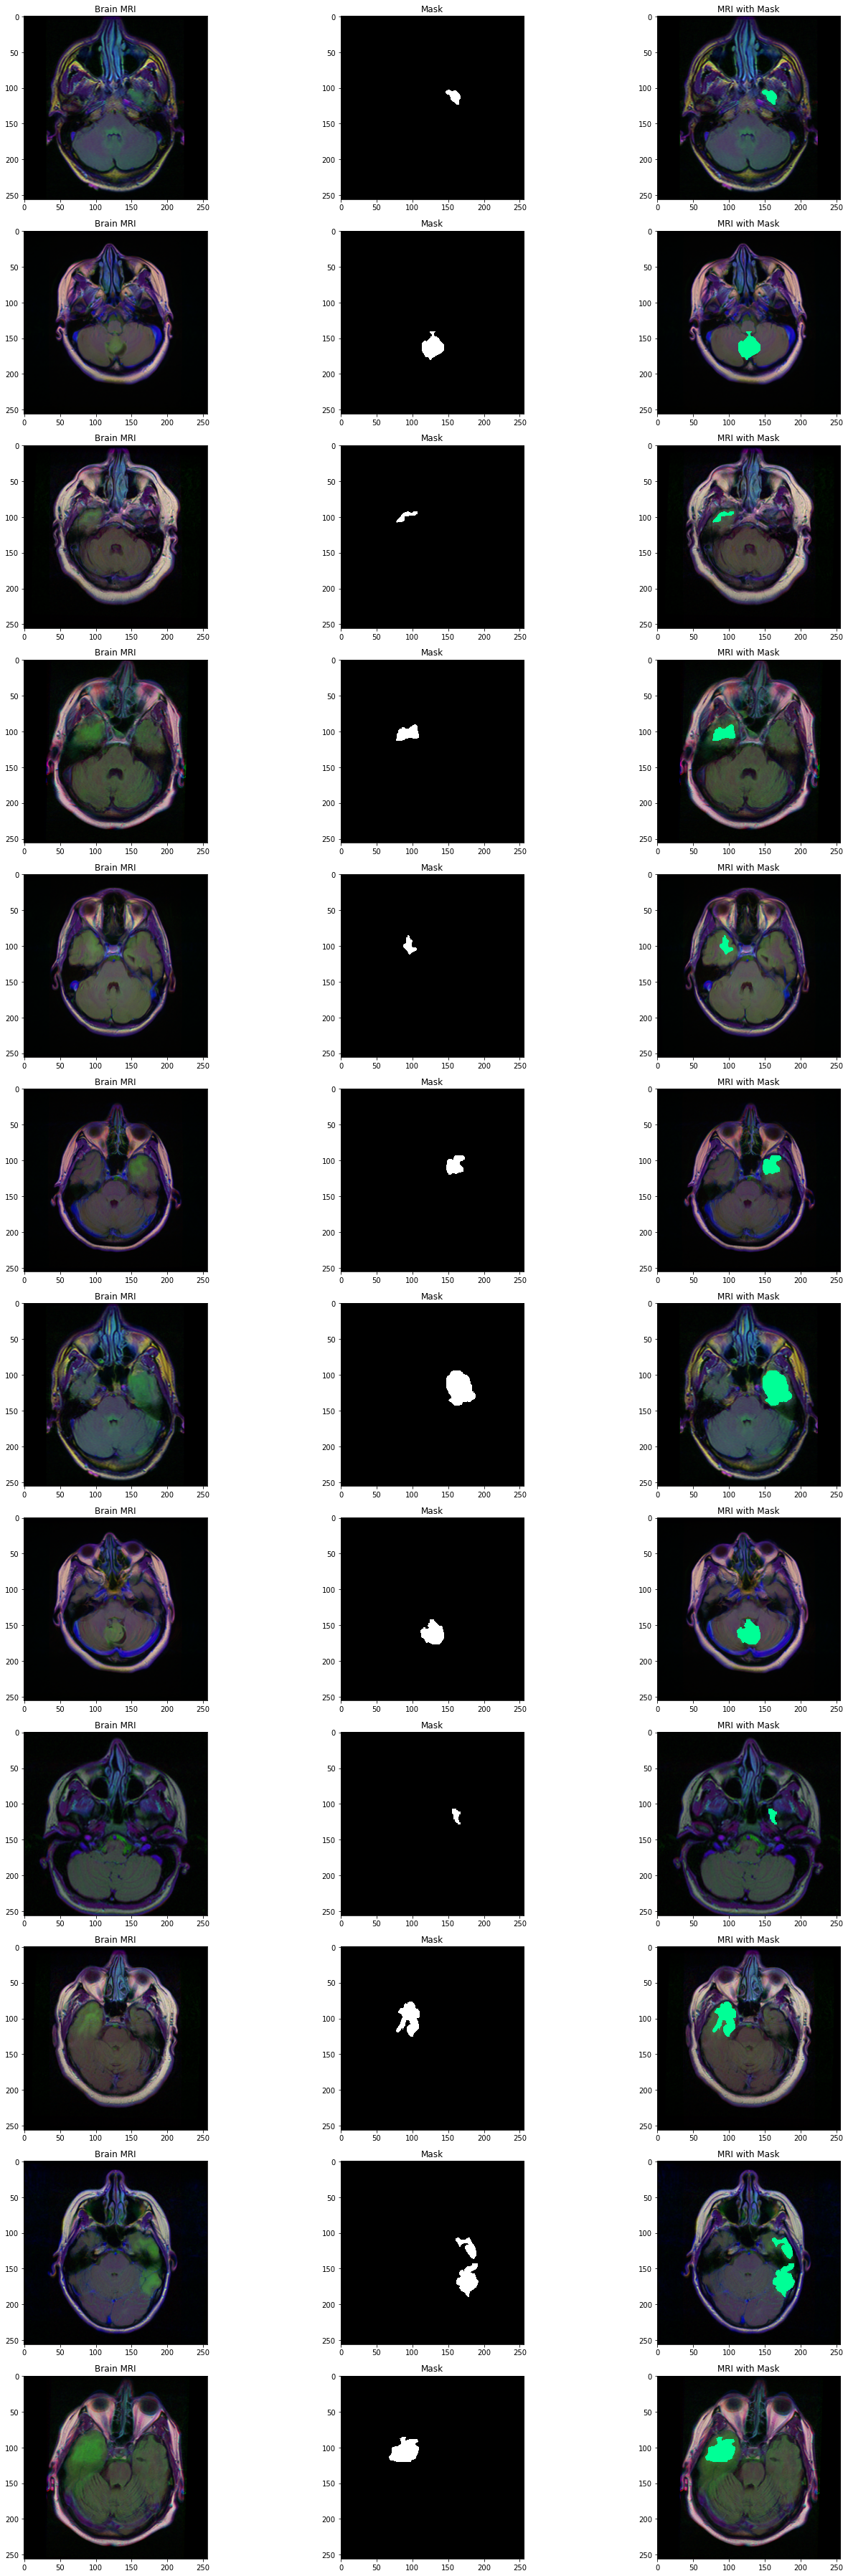

In [13]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# 5: CRETING TEST, TRAIN & VAL SET

In [14]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [15]:
from sklearn.model_selection import train_test_split
SEED = 123456
import os
import random as rn
import numpy as np

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

train, test = train_test_split(brain_df_train, test_size=0.15, random_state = 123456)

In [16]:

from keras_preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1, rotation_range = 15, horizontal_flip = True, vertical_flip = True)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# 6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

# 7: CLASSIFIACTION MODEL EVALUATION

234700800/234698864 [==============================] - 3s 0us/step
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.6846 - false_negatives: 1004.0000
Epoch 00001: val_loss improved from inf to 0.66361, saving model to clf-ResNet152-weights.hdf5
187/187 [==============================] - 102s 547ms/step - loss: 0.6846 - false_negatives: 1004.0000 - val_loss: 0.6636 - val_false_negatives: 116.0000
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.5799 - false_negatives: 920.0000
Epoch 00002: val_loss did not improve from 0.66361
187/187 [==============================] - 80s 430ms/step - loss: 0.5799 - false_negatives: 920.0000 - val_loss: 0.7546 - val_false_negatives: 117.0000
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.5125 - false_negatives: 758.0000
Epoch 00003: val_loss did not improve from 0.66361
187/187 [==============================] - 80s 429ms/step - loss: 0.5125 - false_negatives: 758.0000 - val_loss: 1

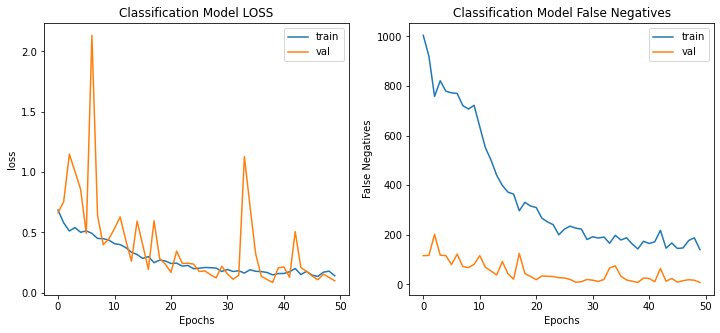

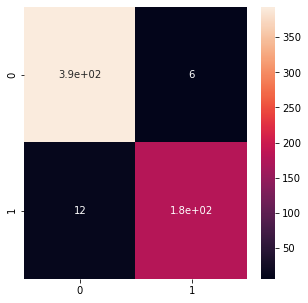

In [17]:
# Train ResNet152
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet152


clf_model = ResNet152(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

for layer in clf_model.layers:
    layers.trainable = False
    
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.FalseNegatives()]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-ResNet152-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
# model_json = model.to_json()
# with open("clf-resnet50-model.json", "w") as json_file:
#    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['false_negatives']);
plt.plot(h.history['val_false_negatives']);
plt.title("Classification Model False Negatives");
plt.ylabel("False Negatives");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, false_neg = model.evaluate(test_generator)
print("Test False Negatives : ".format(false_neg))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("ResNet152")

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)

Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.7592 - false_negatives_1: 1009.0000
Epoch 00001: val_loss improved from inf to 11.48650, saving model to clf-ResNet152_2-weights.hdf5
187/187 [==============================] - 83s 445ms/step - loss: 0.7592 - false_negatives_1: 1009.0000 - val_loss: 11.4865 - val_false_negatives_1: 203.0000
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.5158 - false_negatives_1: 806.0000
Epoch 00002: val_loss improved from 11.48650 to 1.07948, saving model to clf-ResNet152_2-weights.hdf5
187/187 [==============================] - 81s 432ms/step - loss: 0.5158 - false_negatives_1: 806.0000 - val_loss: 1.0795 - val_false_negatives_1: 118.0000
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.4646 - false_negatives_1: 746.0000
Epoch 00003: val_loss improved from 1.07948 to 0.75079, saving model to clf-ResNet152_2-weights.hdf5
187/187 [==============================] - 81s 434ms/step - los

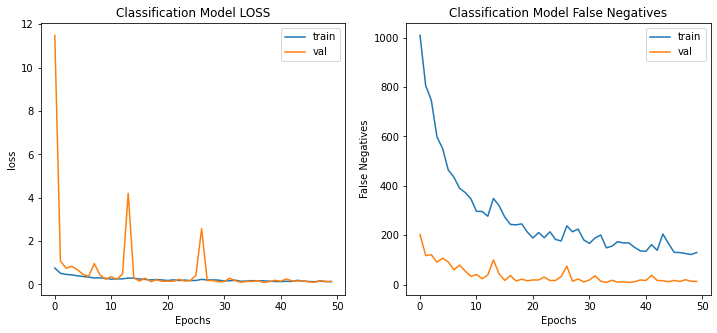

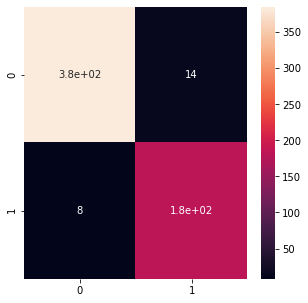

In [18]:
# Train ResNet152_2
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet152


clf_model = ResNet152(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

for layer in clf_model.layers:
    layers.trainable = False
    
head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.FalseNegatives()]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
checkpointer = ModelCheckpoint(filepath="clf-ResNet152_2-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]
h.history={}
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
# model_json = model.to_json()
# with open("clf-resnet50-model.json", "w") as json_file:
#    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['false_negatives_1']);
plt.plot(h.history['val_false_negatives_1']);
plt.title("Classification Model False Negatives");
plt.ylabel("False Negatives");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, false_neg = model.evaluate(test_generator)
print("Test False Negatives : ".format(false_neg))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("ResNet152_2")

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.5458 - false_negatives_2: 682.0000
Epoch 00001: val_loss improved from inf to 0.58971, saving model to clf-MobileNet-weights.hdf5
187/187 [==============================] - 65s 349ms/step - loss: 0.5458 - false_negatives_2: 682.0000 - val_loss: 0.5897 - val_false_negatives_2: 63.0000
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.2850 - false_negatives_2: 297.0000
Epoch 00002: val_loss did not improve from 0.58971
187/187 [==============================] - 56s 297ms/step - loss: 0.2850 - false_negatives_2: 297.0000 - val_loss: 0.7634 - val_false_negatives_2: 56.0000
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.2478 - false_negatives_2: 250.0000
Epoch 00003: val_loss improved from 0.58971 to 0.15218, saving model to clf-MobileNet-weights.hdf5
187/187 [==============================] - 60s 319ms/step -

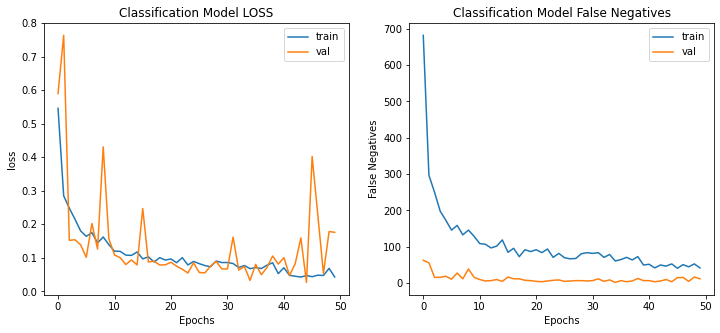

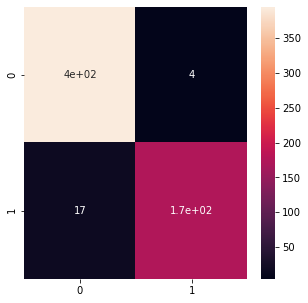

In [19]:
# Train MobileNet
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

for layer in clf_model.layers:
    layers.trainable = False
    
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.35)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.FalseNegatives()]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-MobileNet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
# model_json = model.to_json()
# with open("clf-resnet50-model.json", "w") as json_file:
#    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['false_negatives_2']);
plt.plot(h.history['val_false_negatives_2']);
plt.title("Classification Model False Negatives");
plt.ylabel("False Negatives");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, false_neg = model.evaluate(test_generator)
print("Test False Negatives : ".format(false_neg))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("MobileNet")

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)

Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.5799 - false_negatives_3: 638.0000
Epoch 00001: val_loss improved from inf to 0.67915, saving model to clf-MobileNet-2-weights.hdf5
187/187 [==============================] - 57s 307ms/step - loss: 0.5799 - false_negatives_3: 638.0000 - val_loss: 0.6792 - val_false_negatives_3: 53.0000
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.2427 - false_negatives_3: 240.0000
Epoch 00002: val_loss improved from 0.67915 to 0.28501, saving model to clf-MobileNet-2-weights.hdf5
187/187 [==============================] - 56s 300ms/step - loss: 0.2427 - false_negatives_3: 240.0000 - val_loss: 0.2850 - val_false_negatives_3: 27.0000
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.1888 - false_negatives_3: 176.0000
Epoch 00003: val_loss improved from 0.28501 to 0.10216, saving model to clf-MobileNet-2-weights.hdf5
187/187 [==============================] - 62s 334ms/step - loss: 0.18

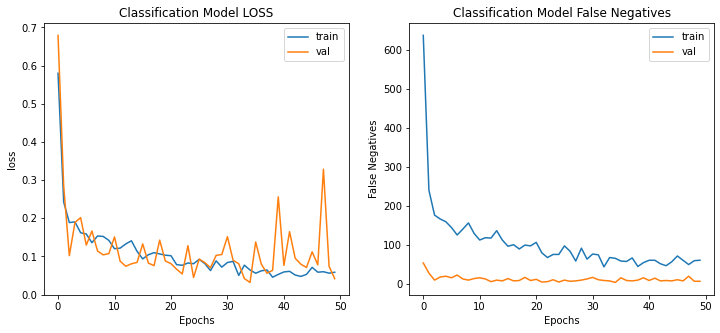

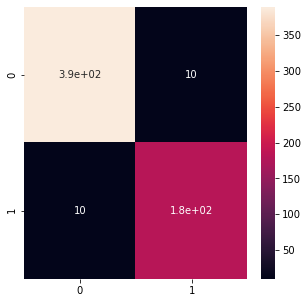

In [20]:
# Train MobileNet-2
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

for layer in clf_model.layers:
    layers.trainable = False

head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(128, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.FalseNegatives()]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-MobileNet-2-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
# model_json = model.to_json()
# with open("clf-resnet50-model.json", "w") as json_file:
#    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['false_negatives_3']);
plt.plot(h.history['val_false_negatives_3']);
plt.title("Classification Model False Negatives");
plt.ylabel("False Negatives");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, false_neg = model.evaluate(test_generator)
print("Test False Negatives : ".format(false_neg))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("MobileNet-2")

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)


Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.7503 - false_negatives_4: 566.0000
Epoch 00001: val_loss improved from inf to 0.38253, saving model to clf-MobileNet-3-weights.hdf5
187/187 [==============================] - 57s 303ms/step - loss: 0.7503 - false_negatives_4: 566.0000 - val_loss: 0.3825 - val_false_negatives_4: 41.0000
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.2323 - false_negatives_4: 262.0000
Epoch 00002: val_loss did not improve from 0.38253
187/187 [==============================] - 56s 299ms/step - loss: 0.2323 - false_negatives_4: 262.0000 - val_loss: 0.4073 - val_false_negatives_4: 38.0000
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.2189 - false_negatives_4: 222.0000
Epoch 00003: val_loss improved from 0.38253 to 0.26746, saving model to clf-MobileNet-3-weights.hdf5
187/187 [==============================] - 65s 347ms/step - loss: 0.2189 - false_negatives_4: 222.0000 - val_loss: 0.267

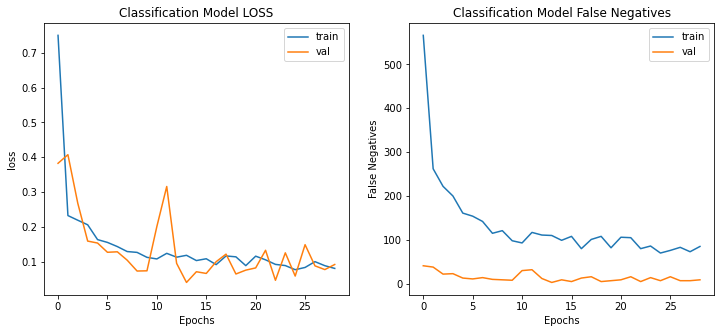

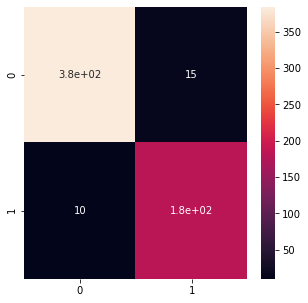

In [21]:
# Train MobileNet-3
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()

for layer in clf_model.layers:
    layers.trainable = False
    
head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(128, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.FalseNegatives()]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-MobileNet-3-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
# model_json = model.to_json()
# with open("clf-resnet50-model.json", "w") as json_file:
#    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['false_negatives_4']);
plt.plot(h.history['val_false_negatives_4']);
plt.title("Classification Model False Negatives");
plt.ylabel("False Negatives");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, false_neg = model.evaluate(test_generator)
print("Test False Negatives : ".format(false_neg))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("MobileNet-3")

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)


9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 0.6680 - false_negatives_5: 739.0000
Epoch 00001: val_loss improved from inf to 7.77119, saving model to clf-MobileNetV2-weights.hdf5
187/187 [==============================] - 60s 319ms/step - loss: 0.6680 - false_negatives_5: 739.0000 - val_loss: 7.7712 - val_false_negatives_5: 117.0000
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 0.3384 - false_negatives_5: 340.0000
Epoch 00002: val_loss improved from 7.77119 to 5.15844, saving model to clf-MobileNetV2-weights.hdf5
187/187 [==============================] - 70s 376ms/step - loss: 0.3384 - false_negatives_5: 340.0000 - val_loss: 5.1584 - val_false_negatives_5: 162.0000
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 0.3483 - false_negatives_5: 308.0000
Epoch 00003: val_loss improved from 5.15844 to 2.49970, saving model to clf-MobileNetV2-weights.hdf5
187/1

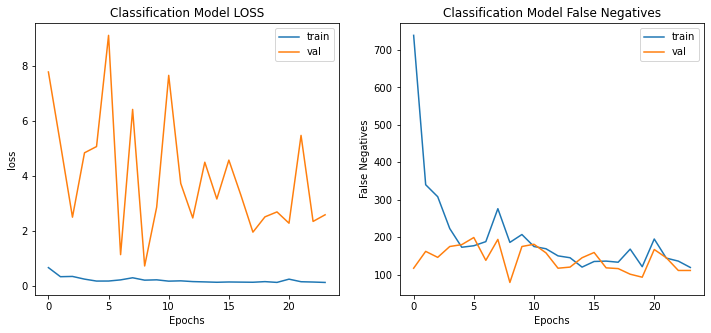

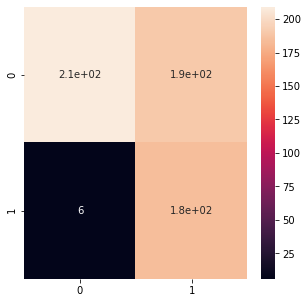

In [22]:
# Train MobileNetV2
# run a different model using the same dataset and data split
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 

import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# clf_model.summary()


for layer in clf_model.layers:
    layers.trainable = False
    
head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(128, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=[tf.keras.metrics.FalseNegatives()]
             )
# model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-MobileNetV2-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
# model_json = model.to_json()
# with open("clf-resnet50-model.json", "w") as json_file:
#    json_file.write(model_json)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['false_negatives_5']);
plt.plot(h.history['val_false_negatives_5']);
plt.title("Classification Model False Negatives");
plt.ylabel("False Negatives");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

_, false_neg = model.evaluate(test_generator)
print("Test False Negatives : ".format(false_neg))

prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
model.save("MobileNetV2")

for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)